In [1]:
from google.colab import drive
import os

drive.mount('/content/gdrive', force_remount=True)
path = '/content/gdrive/My Drive/Data-Centric_Competition/Github_save/Data-Competition'
os.chdir(path)

Mounted at /content/gdrive


In [2]:
%matplotlib inline

import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
!pip install -U albumentations

In [4]:
!pip install -r ./requirements.txt

# Dataset visualization
## Set up

In [5]:
import pandas as pd
import numpy as np
import glob
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_TRAIN = './dataset_origin/images/train'
DIR_VAL = './dataset_origin/images/val'
DIR_TEST = './dataset_origin/images/public_test'

In [6]:
train_df = pd.read_csv('./dataset_origin/train_csv.csv', index_col=False)
valid_df = pd.read_csv('./dataset_origin/val_csv.csv', index_col=False)
test_df = pd.read_csv('./dataset_origin/test_csv.csv', index_col=False)

print(f'Number of samples in training dataset: {str(len(train_df["image_id"].unique()))}')
print(f'Number of samples in val dataset: {str(len(valid_df["image_id"].unique()))}')
print(f'Number of samples in public test dataset: {str(len(test_df["image_id"].unique()))}')

Number of samples in training dataset: 937
Number of samples in val dataset: 152
Number of samples in public test dataset: 88


## Visualize "train", "val", "public_test" dataset

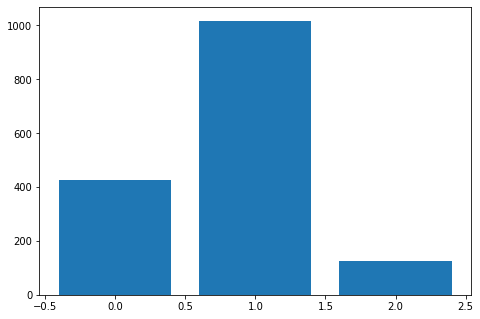

In [7]:
import matplotlib.pyplot as plt

dis = train_df['label'].value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(dis.index), dis.values)
plt.show()

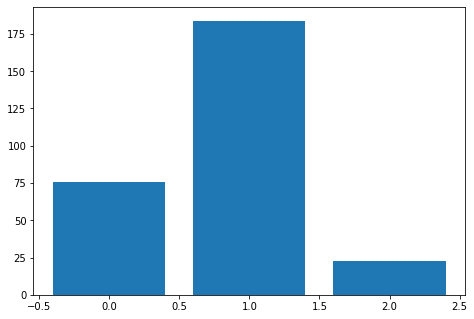

In [8]:
import matplotlib.pyplot as plt

dis = valid_df['label'].value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(dis.index), dis.values)
plt.show()

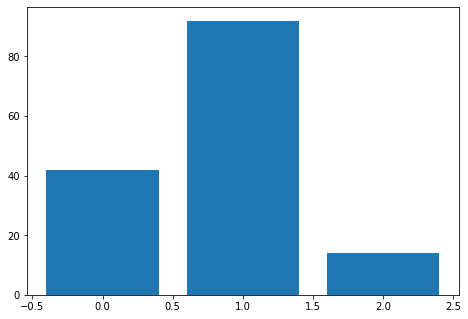

In [9]:
import matplotlib.pyplot as plt

dis = test_df['label'].value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(dis.index), dis.values)
plt.show()

## Dataset construction

In [10]:
# HELPER FUNCTIONS
def load_image(self, index):
  # loads 1 image from dataset, returns img, original hw, resized hw
  """Load 1 image from dataset
  Input:
    index: idx to search for image's id
  Output:
    img, hw_original, hw_resized """
  # Read an image using opencv2
  image_id = self.image_ids[index]
  img = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
    
  assert img is not None, 'Image Not Found ' + imgpath
  h0, w0 = img.shape[:2]  # orig hw
  return img, (h0, w0)  # img, hw_original


def yolo_to_pascal(x, y, w, h, width, height):
  xmax = int((x*width) + (w * width)/2.0)
  xmin = int((x*width) - (w * width)/2.0)
  ymax = int((y*height) + (h * height)/2.0)
  ymin = int((y*height) - (h * height)/2.0)
  return xmin, ymin, xmax, ymax

In [11]:
from sklearn.utils import shuffle
import random

class FPTDataset(Dataset):
  def __init__(self, dataframe, image_dir, transforms=None):
    super().__init__()

    self.df = dataframe  # Annotation & Image's ID dataframe
    self.transforms = transforms  # Albumentation's augmentation
    self.image_ids = shuffle(dataframe['image_id'].unique())  # Image's ID
    self.labels = [np.zeros((0, 4), dtype=np.float32)] * len(self.image_ids) # Image's bboxes
    self.class_labels = [np.zeros((0, 1), dtype=np.float32)] * len(self.image_ids)  # Image's label
    self.img_size = 960
    self.image_dir = image_dir
    im_w = 1280
    im_h = 720

    # Loop through each image (Each image might containt multiple bboxes & labels)
    for i, img_id in enumerate(self.image_ids):
      records = self.df[self.df['image_id'] == img_id]
      boxes = records[['x', 'y', 'w', 'h']].values  # Annotations
      class_label = records[['label']].values
      self.labels[i] = np.array(boxes)
      self.class_labels[i] = class_label

  def __getitem__(self, index: int):
    # DATA AUGMENTATION
    if self.transforms is not None:
      # Load image
      image, (h0, w0) = load_image(self, index)

      # Augmentation
      augmented = self.transforms(image=image, bboxes=self.labels[index], class_labels=self.class_labels[index])
      image = augmented['image']
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR to RGB
      bboxes = augmented['bboxes']
      labels = augmented['class_labels']

      return image, bboxes, labels

  def __len__(self) -> int:
    return self.image_ids.shape[0]


## TRAIN DATASET VISUALIZATION

In [12]:
import random, math


def collate_fn(batch):
    return tuple(zip(*batch))

def aug_resize():
  return A.Compose([
      A.augmentations.geometric.resize.Resize (960, 1280, interpolation=1, always_apply=False, p=1)
  ], p=1.0, bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

def data_visualize(data_df, data_dir, transform):
  dataset_obj = FPTDataset(data_df, data_dir, transform)  # 792 images
  train_data_loader = DataLoader(
      dataset_obj,
      batch_size=64,
      shuffle=True,
      num_workers=4,
      collate_fn=collate_fn
  )

  fig, ax = plt.subplots(8, 8, figsize=(50, 50))
  ax = ax.flatten()
  images, targets, class_labels = next(iter(train_data_loader))
  for i in range(64):  # Go through each batch 
    boxes = targets[i]
    sample = images[i]
    height, width = sample.shape[:2]

    for box in boxes:
      # Convert from Yolo to Pascal_voc
      box = yolo_to_pascal(box[0], box[1], box[2], box[3], width, height)
      # Drawing bounding box
      cv2.rectangle(sample,
                (int(box[0]), int(box[1])),
                (int(box[2]), int(box[3])),
                220, 3)

    ax[i].imshow(sample)  # Visualize a sample for each batch
  plt.show()

In [ ]:
data_visualize(train_df, DIR_TRAIN, aug_resize())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
data_visualize(train_df, DIR_TRAIN, aug_resize())

Output hidden; open in https://colab.research.google.com to view.

# VAL DATASET VISUALIZATION

In [13]:
data_visualize(valid_df, DIR_VAL, aug_resize())

Output hidden; open in https://colab.research.google.com to view.

# PUBLIC_TEST DATASET VISUALIZATION

In [ ]:
data_visualize(test_df, DIR_TEST, aug_resize())

Output hidden; open in https://colab.research.google.com to view.